# Notebook for assignment 3.

Course: 1CK130

Deadline: see canvas

Lecturers: Dr. Bram de Moor; Dr. Mirjam Meijer; Emre Kara, MSc


# GROPU 22 - Magda Kantara and Jakub Kuczynski


The company PineApple operates bike rental locations in a big touristic city in Spain, and you consulted for them in a previous assignment. PineApple also operates in other european cities, which are less touristic and with more point-to-point mobility demand, for example by commuters or (non-touristic) visitors that use the bike for the last mile in a public transport situation. In those cities, customers much more frequently return bikes at another location than from where they previously rented them. The technology adopted for this includes unmanned locations where customers can pick up bikes (and drop them off) without human intervention.

Customers can simply take a bike at such a location, ride it to some other location, and drop the bike there again.



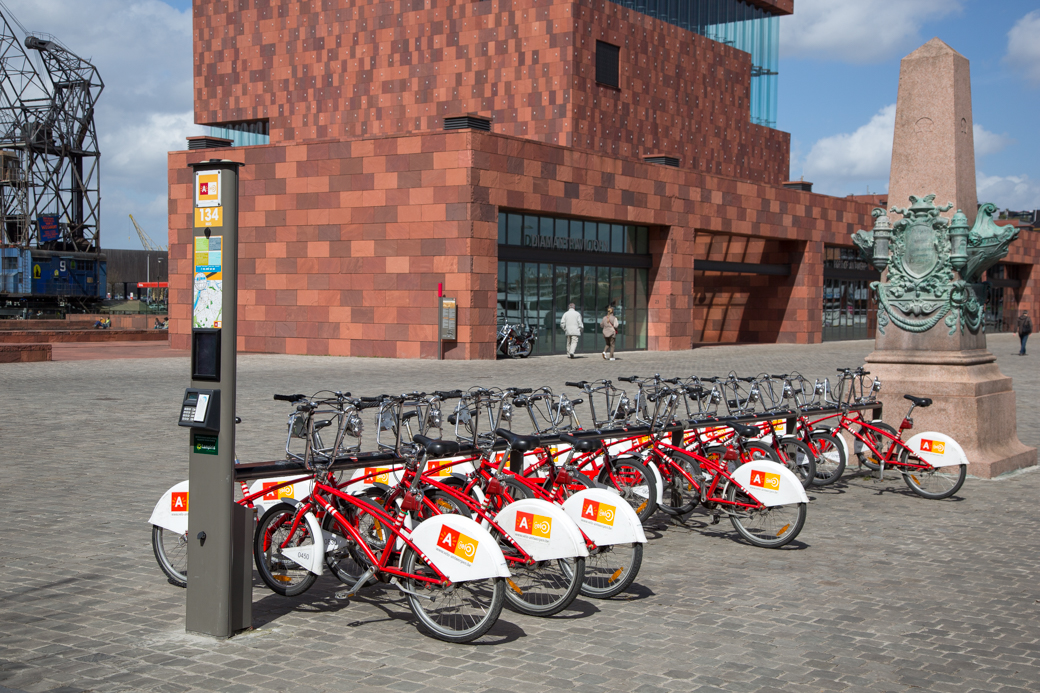

The company was impressed by the results you delivered in your first assignment; it wants to also hire you for analysis of their bike system in the other European city.

For this city, a good initial distribution of bikes may not be sufficient: They need more help with other aspects, e.g. with the actual operations of bike rebalancing. Assignment 3 (this assignment) as well as Assignment 4 (the final assignment) will be centered around that.

Between these two assignments, asssignment 3 will focus purely on data analysis, in order to discover key system parameters like the true demand per location. Indeed, a key challenge for this system is that true demand is not always known because it may not always be registered. Since the bike rental locations are unmanned, it is non-trivial to work out the true demand for mobility at a location when that location is empty, as customers may choose an alternative mode of transportation in that case, and the demand remains unregistered.

In [18]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
# #drive.mount('/Data_A2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After succesfully mounting the drive, below code loads the data. Note that this specific file_path only works when you placed the excel file in a subfolder '1CK130' of 'My Drive' on Google Drive. The data contains the coordinates of the various locations.

In [19]:
import math
file_path = '/content/drive/My Drive/1CK130/bike_locations_data.xlsx'
df = pd.read_excel(file_path)

class Location:
    def __init__(self, loc, x, y):
        self.loc = loc
        self.x = x
        self.y = y


    def distance(self, other):
        return math.sqrt((self.x - other.x) ** 2 + (self.y - other.y) ** 2)
    def __repr__(self):
        return f"loc{self.loc}(x={self.x}, y={self.y})"
#this loads the data into the locations list
locations = [Location(loc=int(row['loc']), x=row['x'], y=row['y']) for _, row in df.iterrows()]


Let's create a quick figure to visualize the various locations with their location number on a map.

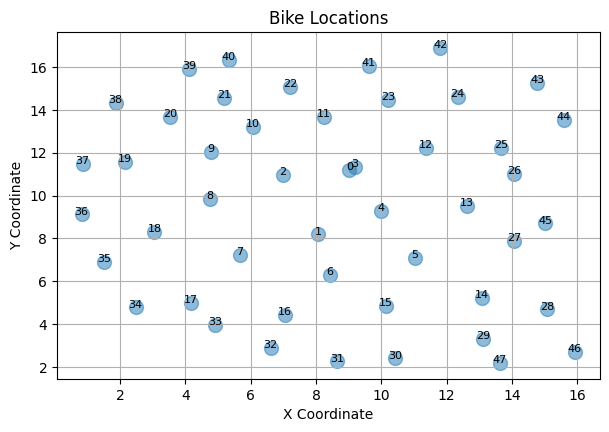

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 4.5))
scatter = plt.scatter(df['x'], df['y'], s=100, alpha=0.5)

for i, point in df.iterrows():
    plt.text(point['x'], point['y'], f"{int(point['loc'])}", fontsize=8, ha='center')
plt.title('Bike Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

Your final goal (for the final assignment 4 that you will receive later) will be to come up with bike rebalancing policies that will help the system to run more smoothly. For the present assignment 3, we work towards that goal by analyzing some data, to get a better idea of the true demand for mobility in the system.

To that end, you collected trip data from the system for 6 representative operating days, some of which were a bit more busy than others. Note that these were not consequtive days, and that the company engages in rebalancing, so for multiple reasons the starting inventory of one day need not match the ending inventory of the other day. The data is given in the form of rows containing information on trips:
* `oper_day`: an id (between 0 and 5) that connects to the day for which this data was collected. The data contains all trips that were started between 00:00 and 23:59 on the respective days.
* `wdr_loc`: location where the bike was picked up - referring to the numbering in the location data above.
* `wdr_b`: number of bikes at the withdrawal location, just after this bike was withdrawn.
* `wdr_t`: time at which the bike was withdrawn (number representing the amount of hours after 00:00. I.e. 6.5 refers to six and a half hours after midnight, i.e. 06:30AM.)
* `ret_loc`: location where the bike was returned.
* `ret_b`: number of bikes at the return location, just after this bike was returned.
* `ret_t`: time at which bike was returned (same encoding as `wdr_t`).

Below is some code that can load this data. To run it, you must first save file in your Google Drive and mount the drive (see code in first code cell above):

In [21]:
# Load transactions data
file_path = '/content/drive/My Drive/1CK130/transactions_data.xlsx'
data = pd.read_excel(file_path)

# Group by operating_day_id
grouped_data = data.groupby('oper_day')

# Store data for each day
daily_data = {day: group.drop(columns='oper_day') for day, group in grouped_data}

# Display sample
for day in daily_data:
    print(f"Data for Day {day} (first 5 rows):")
    print(daily_data[day].head(), "\n")


Data for Day 0 (first 5 rows):
   wdr_loc  wdr_b     wdr_t  ret_loc  ret_b     ret_t
0        8     35  5.024877        5     27  6.167177
1        5     25  5.078680       14     42  5.543884
2       29     26  5.080032        8     31  6.407872
3        4     26  5.097119       25     14  5.543075
4       34     16  5.103508       23     22  6.111822 

Data for Day 1 (first 5 rows):
      wdr_loc  wdr_b     wdr_t  ret_loc  ret_b     ret_t
8370       32     22  5.034253       13     21  6.193552
8371        4     22  5.037247       17     26  5.890561
8372       29     19  5.142344       13     21  5.946445
8373       17     25  5.157454       13     22  6.453905
8374       20     13  5.280598       21     29  5.590164 

Data for Day 2 (first 5 rows):
       wdr_loc  wdr_b     wdr_t  ret_loc  ret_b     ret_t
15989        2     34  5.007197        9     40  5.229195
15990       15     20  5.007871       15     21  5.204072
15991       26     11  5.008282        5     24  5.503213
15992

##Goals of data analysis

To test various approaches for operational rebalancing policies, it will be crucial to obtain an accurate estimate of various elements in the problem, especially the demand and travel times.

Of course, we could directly use the demand arising from the `transactions_data` lines, but note that there were some situations where certain bike locations ran out of stock.

In [22]:

for i in range(5):
    print(daily_data[i].shape[0]) # number of trips per day

# Take a closer look at Day 0
day_zero = daily_data[0]
#get the rows where no bikes were left after a withdrawal.
zero_withdrawn_bikes = day_zero[day_zero['wdr_b'] == 0]
print(f"Number of rows on day zero which involved the last bike being withdrawn: {zero_withdrawn_bikes.shape[0]}")
print(f"Total number of trips for day zero: {day_zero.shape[0]}")


8370
7619
8730
6678
10299
Number of rows on day zero which involved the last bike being withdrawn: 554
Total number of trips for day zero: 8370


Now, when the last bike is withdrawn, and a new customer would arrive that would normally want to use a bike, that customer cannot withdraw a bike and would typically choose a different mode of transport. So suppose the total number of withdrawals at a location over a day is 140. This does not need to imply that the total _demand_ was 140 - it may be higher and some people may have found different solutions for their mobility needs. This is mainly the case when a certain location stocks out completely for a period of time.

One goal of the data analysis is to recover the real demand from the data somehow, which requires us to make some estimates. A related goal will be to recover the true pattern of demand over the day, for each of the locations. Since transportation is a rather universal need, we might expect similar demand patterns for various locations, but some locations have a higher demand than others.

The goal of all this analysis is to develop a more accurate simulation model, that does not directly utilize past trip data, but actually estimates the true underlying demand per location, and converts this to a demand rate per time of day. In addition to the demand data for each origin, also the destination data needs to somehow be estimated.

A final ingredient would be travel times, which would likely involve a distance dependent estimation procedure. For purposes of estimating distances, you would normally use a solution like the google maps API. But for the purposes of this course, it is likely sufficient to simply use the Euclidean distance (there is a function provided in Location that can compute it allready) - it would in many cases, for medium to larger distances, have an approximately linear relationship with the distance over the road. *** Depending on the speed of biking, the travel time from A to B may vary [added as a bit of a hint towards taking into account the speed or fitting a distribution] ***

Note that with this information (amount of withdrawals per time of day per origin location + probability of destination locations + travel times) we would be able to make an event-driven simulation of the whole system (like we did in assignment 2). This will be the starting point for assignment 4 (the next assignment).

**Assignment**



Please hand in the assignment by simply downloading the pynb file and submitting that in canvas. Add some text fields describing the choices that you made, and the main outcomes of the analysis:
1. An estimate of the demand pattern per hour of day, for each of the locations. I.e. for each location analyze what percentage of total demand on a day tends to happen for various hours of the day.
2. The average real daily demand for each of the locations, taking into account an estimate of the demand that is lost.
3. Describe how your answers to 1 and 2 can be used to simulate customer arrivals.
3. An estimate of destination probabilities for each origin location. I.e., considering that a bike is withdrawn from a specific location, what are the probabilities that the customer will want to return that bike to each of the 48 locations in the network?
4. An estimate of the travel time for each origin-destination pair. I.e., suppose a customer travels from location i to location j, what is the expected travel time and what standard deviation do you expect. Note that the amount of data on travel times, which is influenced by distance, is (very) limited in some cases. Explain how you deal with this.

When grading, we consider
* Does your code run? Is it clear and well-annotated?
* How appropriate are the various steps taken? Did you clearly explain (in separate text cells) what analysis steps you took when determining each of the above estimates.
* How innovative is your approach to deal with challenges such as limited data and unobserved demand?
* Do you present your results in a clear, statistically correct, and visually appealing manner?
* Do you interpret and discuss your results in an appropriate way?

To make the code readable, we suggest that you tackle the four estimation questions one by one, explaining in each case what you did and why.

## 1. Demand Patterns

To understand the demand pattern, I aggregate withdrawal data across all 6 days for each location. I define the 'demand pattern' as the percentage of total daily withdrawals that occur during each hour of the day. This normalization allows comparison across locations with different total volumes.

**Approach:**  
Aggregate withdrawals per hour for each location, average over 6 days, then convert to percentages of daily demand.

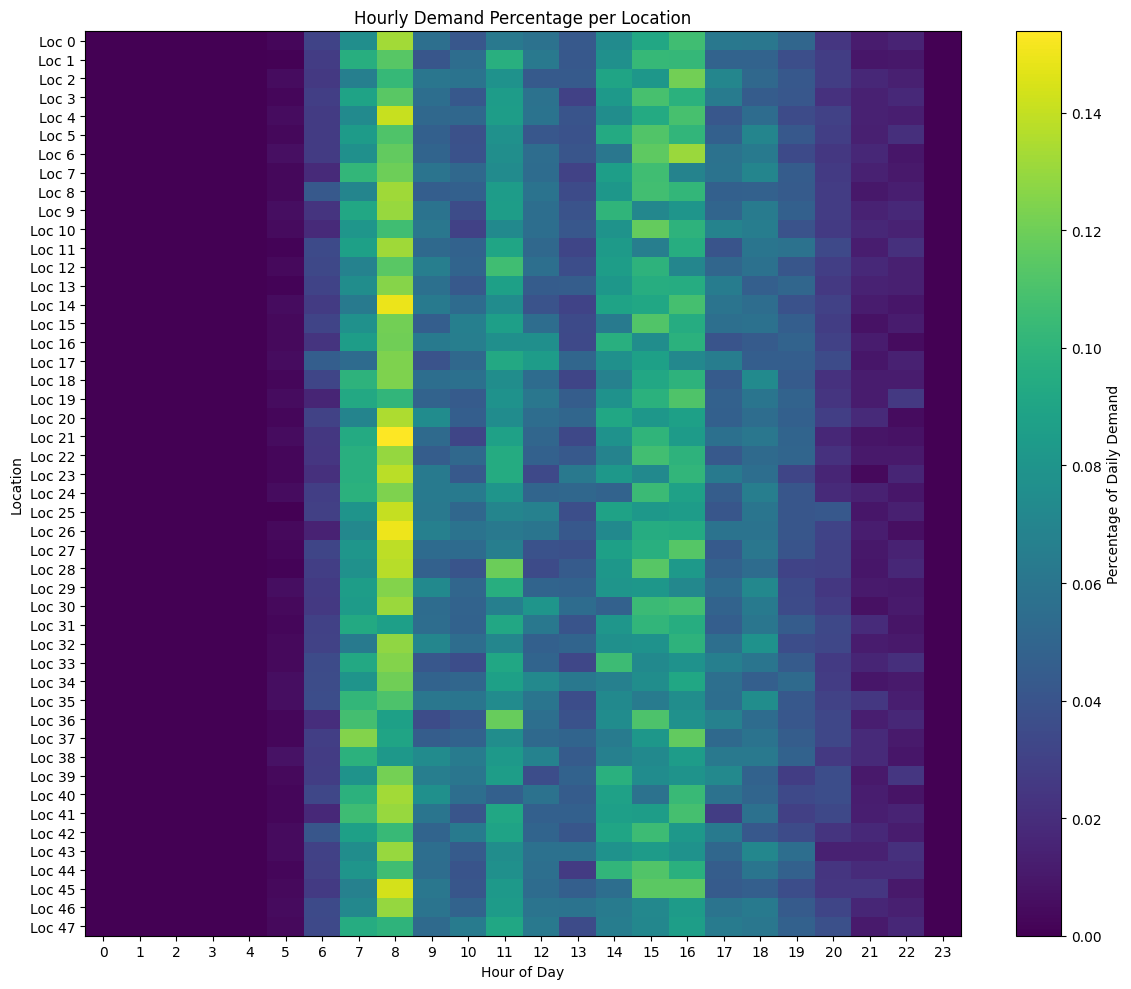


Peak demand hours by location (Sample):
Location 0: 8 - 9 (13.3%)
Location 1: 8 - 9 (11.4%)
Location 2: 16 - 17 (12.1%)
Location 3: 8 - 9 (11.4%)
Location 4: 8 - 9 (14.1%)
Location 5: 15 - 16 (11.2%)
Location 6: 16 - 17 (13.1%)


In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Configuration
NUM_LOCATIONS = 48
HOURS_IN_DAY = 24
NUM_DAYS = 6

# ========== STEP 1: Initialize data structure ==========
# Create nested dictionary to store withdrawal counts per hour
# Structure: loc_dict_wdr['Location 0']['8 - 9'] = number of withdrawals
loc_dict_wdr = {
    f'Location {i}': {f'{h} - {h+1}': 0 for h in range(HOURS_IN_DAY)}
    for i in range(NUM_LOCATIONS)
}

# ========== STEP 2: Count withdrawals per location per hour ==========
for day in range(NUM_DAYS):
    day_data = daily_data[day]

    for row in day_data.itertuples():
        if pd.notna(row.wdr_loc):
            loc_id = int(row.wdr_loc)

            if 0 <= loc_id < NUM_LOCATIONS:
                loc_key = f'Location {loc_id}'
                hour_int = int(row.wdr_t)  # Extract hour (e.g., 8.5 becomes 8)
                if hour_int >= 24: hour_int = 23  # Handle edge case
                time_bin = f'{hour_int} - {hour_int + 1}'
                loc_dict_wdr[loc_key][time_bin] += 1

# ========== STEP 3: Calculate average over 6 days ==========
for loc in loc_dict_wdr:
    for time_bin in loc_dict_wdr[loc]:
        loc_dict_wdr[loc][time_bin] /= NUM_DAYS

# ========== STEP 4: Convert counts to percentages ==========
# This normalizes demand patterns so we can compare locations
loc_percentages = {}
for loc, hourly_counts in loc_dict_wdr.items():
    total = sum(hourly_counts.values())  # Total daily withdrawals

    if total > 0:
        # Convert each hour's count to percentage of daily total
        loc_percentages[loc] = {
            time_bin: count / total
            for time_bin, count in hourly_counts.items()
        }
    else:
        loc_percentages[loc] = {time_bin: 0 for time_bin in hourly_counts}

# ========== STEP 5: Create heatmap visualization ==========
# Build 2D array: rows = locations, columns = hours
heat_data = [
    [loc_percentages[f'Location {i}'][f'{h} - {h+1}'] for h in range(HOURS_IN_DAY)]
    for i in range(NUM_LOCATIONS)
]

plt.figure(figsize=(12, 10))
plt.imshow(heat_data, cmap='viridis', aspect='auto')
plt.colorbar(label='Percentage of Daily Demand')
plt.xlabel('Hour of Day')
plt.ylabel('Location')
plt.title('Hourly Demand Percentage per Location')
plt.xticks(range(HOURS_IN_DAY), [f'{h}' for h in range(HOURS_IN_DAY)])
plt.yticks(range(NUM_LOCATIONS), [f'Loc {i}' for i in range(NUM_LOCATIONS)])
plt.tight_layout()
plt.show()

# Print sample peak hours
print("\nPeak demand hours by location (Sample):")
for i in range(7):
    loc = f'Location {i}'
    best_hour = max(loc_percentages[loc], key=loc_percentages[loc].get)
    peak_pct = loc_percentages[loc][best_hour]
    print(f"{loc}: {best_hour} ({peak_pct:.1%})")

### Discussion results Question 1
From our visualisation, we can infer some information about the system. First of all, heatmap shows a clear morning peak around 08:00–09:00 for most locations, indicating stron demand for bikes. Some stations also have a second peak in the afternoon (14:00–16:00), which likely reflects return trips. Demand is very small during night hours, so bike usage is concentrated mostly during daytime. While the overall pattern is similar across locations, the exact peak hour and intensity differ, meaning that demand is location-specific and not uniform across the network.

### Assumptions and limitations of modeling
1. The six days of data accurately represent demand.


2. The hour is taken as int(wdr_t) rounding down is assumed acceptable.
3. Each hour is treated as a separate time bin.


## 2. Real Daily Demand

The observed demand from transactions is censored - when locations run out of bikes, customers are turned away and not recorded. To estimate the true demand, I use a rate-based imputation method:

1. Identify stockout periods (when bikes = 0)
2. Calculate demand rate (withdrawals/minute) during available periods
3. Impute lost demand = rate × stockout duration
4. Real demand = observed + lost demand

Estimated Real Daily Demand per Location:
Location 0: 249.37
Location 1: 238.56
Location 2: 241.01
Location 3: 255.89
Location 4: 250.67
Location 5: 256.09
Location 6: 264.38
Location 7: 238.40
Location 8: 250.38
Location 9: 251.33
Location 10: 247.72
Location 11: 260.37
Location 12: 224.36
Location 13: 201.89
Location 14: 202.39
Location 15: 131.55
Location 16: 134.89
Location 17: 132.83
Location 18: 145.71
Location 19: 139.48
Location 20: 137.92
Location 21: 150.17
Location 22: 130.95
Location 23: 136.80
Location 24: 135.16
Location 25: 135.92
Location 26: 146.05
Location 27: 147.27
Location 28: 136.17
Location 29: 146.00
Location 30: 135.05
Location 31: 137.20
Location 32: 141.88
Location 33: 140.01
Location 34: 135.36
Location 35: 142.89
Location 36: 136.27
Location 37: 131.10
Location 38: 155.01
Location 39: 141.23
Location 40: 141.31
Location 41: 138.36
Location 42: 126.01
Location 43: 128.84
Location 44: 138.03
Location 45: 134.02
Location 46: 519.39
Location 47: 530.08


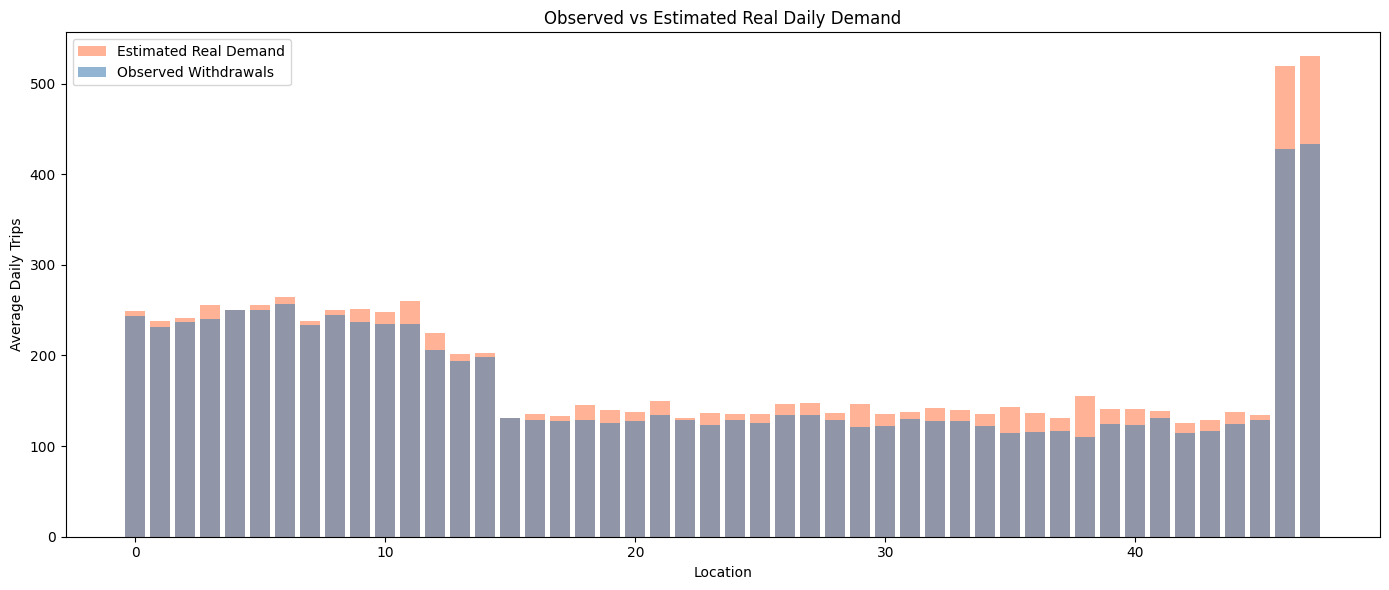

In [24]:
# ========== STEP 1: Initialize data structures ==========
real_demand_totals = {i: 0.0 for i in range(NUM_LOCATIONS)}
hourly_stats = {}  # Will store: hourly_stats[loc][day][hour] = {'obs': count, 'avail_min': minutes}

# ========== STEP 2: Identify stockouts and calculate available time ==========
for loc_id in range(NUM_LOCATIONS):
    hourly_stats[loc_id] = {}

    for day in range(NUM_DAYS):
        # Initialize: assume full 60 minutes available per hour
        hourly_stats[loc_id][day] = {h: {'obs': 0, 'avail_min': 60.0} for h in range(HOURS_IN_DAY)}

        day_data = daily_data[day]

        # --- Extract withdrawal and return events ---
        wdrs = day_data[day_data['wdr_loc'] == loc_id][['wdr_t', 'wdr_b']].copy()
        wdrs['type'] = 'wdr'
        wdrs.rename(columns={'wdr_t': 'time', 'wdr_b': 'stock'}, inplace=True)

        rets = day_data[day_data['ret_loc'] == loc_id][['ret_t', 'ret_b']].copy()
        rets['type'] = 'ret'
        rets.rename(columns={'ret_t': 'time', 'ret_b': 'stock'}, inplace=True)

        # Merge and sort events by time (chronological order)
        events = pd.concat([wdrs, rets]).sort_values('time')

        # --- Find stockout periods ---
        # A stockout starts when a withdrawal leaves 0 bikes, ends when a bike is returned
        stockouts = []
        on_stockout = False
        start_time = 0.0

        for row in events.itertuples():
            # Stockout begins
            if row.type == 'wdr' and row.stock == 0 and not on_stockout:
                on_stockout = True
                start_time = row.time
            # Stockout ends
            elif row.type == 'ret' and on_stockout:
                on_stockout = False
                stockouts.append((start_time, row.time))

        # If still in stockout at end of day
        if on_stockout:
            stockouts.append((start_time, 24.0))

        # --- Calculate available time per hour ---
        for h in range(HOURS_IN_DAY):
            t_start = float(h)
            t_end = float(h + 1)

            # Find overlap between stockout periods and this hour
            unavailable = 0.0
            for s_start, s_end in stockouts:
                ov_start = max(s_start, t_start)  # Later of the two starts
                ov_end = min(s_end, t_end)        # Earlier of the two ends
                if ov_end > ov_start:
                    unavailable += (ov_end - ov_start)

            # Convert to minutes
            avail_min = (1.0 - unavailable) * 60.0
            hourly_stats[loc_id][day][h]['avail_min'] = max(0.0, avail_min)

            # Count observed withdrawals in this hour
            obs = len(wdrs[(wdrs['time'] >= t_start) & (wdrs['time'] < t_end)])
            hourly_stats[loc_id][day][h]['obs'] = obs

# ========== STEP 3: Calculate demand rates and impute lost demand ==========
for loc_id in range(NUM_LOCATIONS):
    for h in range(HOURS_IN_DAY):
        # --- Calculate average rate for this location/hour ---
        total_obs = 0
        total_avail_min = 0.0

        for day in range(NUM_DAYS):
            stats = hourly_stats[loc_id][day][h]
            total_obs += stats['obs']
            total_avail_min += stats['avail_min']

        # Compute rate (withdrawals per minute)
        if total_avail_min > 5:  # Need sufficient data
            rate = total_obs / total_avail_min
        else:
            rate = 0.0

        # --- Apply rate to estimate lost demand ---
        for day in range(NUM_DAYS):
            stats = hourly_stats[loc_id][day][h]
            obs = stats['obs']                      # Observed withdrawals
            lost_min = 60.0 - stats['avail_min']   # Minutes unavailable
            lost_demand = rate * lost_min           # Estimated lost demand

            # Real demand = observed + estimated lost
            real_demand_totals[loc_id] += (obs + lost_demand)

# ========== STEP 4: Calculate average daily real demand ==========
print("Estimated Real Daily Demand per Location:")
avg_real_demand = {}
for loc_id in range(NUM_LOCATIONS):
    avg = real_demand_totals[loc_id] / NUM_DAYS
    avg_real_demand[loc_id] = avg
    print(f"Location {loc_id}: {avg:.2f}")

# ========== STEP 5: Visualize observed vs real demand ==========
# Calculate total observed for comparison
total_observed = {i: 0 for i in range(NUM_LOCATIONS)}
for day in range(NUM_DAYS):
    d = daily_data[day]
    counts = d['wdr_loc'].value_counts()
    for loc_id, count in counts.items():
        if pd.notna(loc_id) and 0 <= loc_id < NUM_LOCATIONS:
            total_observed[int(loc_id)] += count

# Prepare data for bar chart
locs = list(range(NUM_LOCATIONS))
obs_vals = [total_observed[i]/NUM_DAYS for i in locs]
real_vals = [avg_real_demand[i] for i in locs]

plt.figure(figsize=(14, 6))
plt.bar(locs, real_vals, alpha=0.6, label='Estimated Real Demand', color='coral')
plt.bar(locs, obs_vals, alpha=0.6, label='Observed Withdrawals', color='steelblue')
plt.xlabel('Location')
plt.ylabel('Average Daily Trips')
plt.title('Observed vs Estimated Real Daily Demand')
plt.legend()
plt.tight_layout()
plt.show()

## Discussion results Question 2
This analysis estimates true daily demand per location by accounting for missed trips during stockouts, using the method described above. The method estimates a withdrawal rate only during the minutes when bikes were available, which avoids inflating demand. It then applies this rate to the unavailable minutes to compute how many trips were likely lost. This produces a more realistic estimate of demand compared to other methods used, for example linear regression and porportional methods. It uses observed behavior and keeps the numbers realistic.


We acknowledge that this method estimates unobserved behaviour, so its accuracy cannot be directly validated. However, the resulting real-demand values appear realistic when compared to the observed-vs-estimated bar chart.This indicates that the method is not simply inflating demand in proportion to stockouts, but instead produces logically consistent estimates that align with expected system behaviour

### Assumptions and Limitations

1. More stockout time means more missed demand :
We assume that if a station has many minutes without bikes, then many customers were unable to rent a bike. This is realistic because empty stations typically occur in high-demand locations.

2. Constant demand rate within each hour:
Withdrawals per available minute reflect the true intensity of demand, so we can impute lost demand from the same rate.

## 3. Simulating Customer Arrivals

To simulate customer arrivals, I combine results from Q1 (hourly patterns) and Q2 (real demand). For each location, I use the total daily demand from Q2 and distribute arrivals throughout the day according to the hourly percentages from Q1. I generate arrivals using a non-homogeneous Poisson process with exponential inter-arrival times.

Number of arrivals generated for Location 0: 256
Expected demand for Location 0: 249.37
First 10 arrival times: ['5.69', '6.17', '6.29', '6.31', '6.34', '6.34', '6.61', '6.73', '6.89', '6.89']


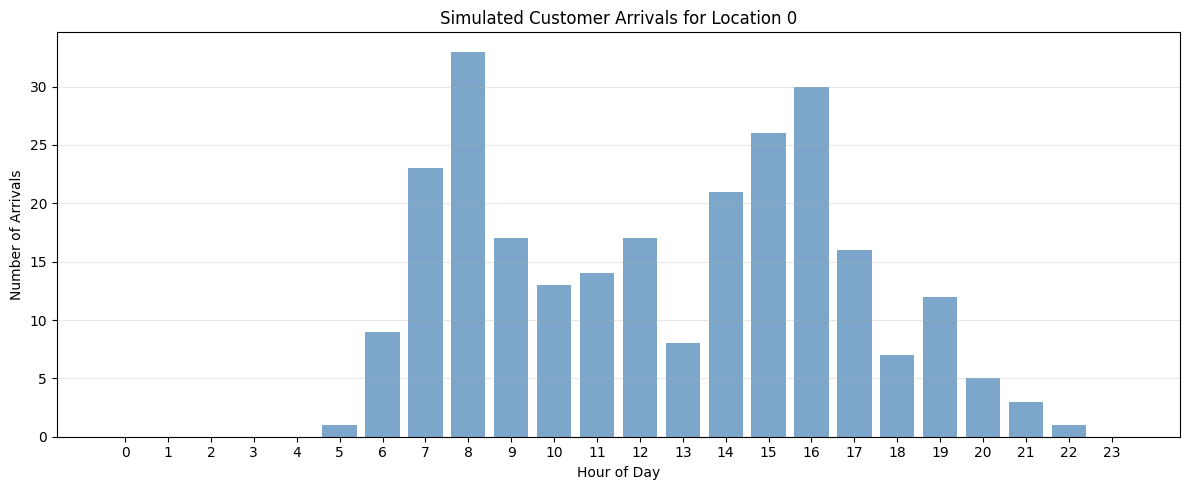


Usage in Simulation:
For each location, call generate_customer_arrivals() to get arrival times.
Then create CustomerArrivalEvent objects and add them to the FutureEventSet.


In [25]:
import numpy as np

def generate_customer_arrivals(location_id, avg_real_demand, loc_percentages):
    """
    Generate customer arrival times for a single location for one day using a Poisson process.

    Args:
        location_id: Location ID (0-47)
        avg_real_demand: Dict with average daily demand per location
        loc_percentages: Dict with hourly percentages per location

    Returns:
        List of arrival times (in hours from 00:00)
    """
    arrivals = []
    loc_key = f'Location {location_id}'
    daily_demand = avg_real_demand[location_id]
    hourly_pcts = loc_percentages[loc_key]

    # ========== Generate arrivals for each hour ==========
    for hour in range(24):
        time_bin = f'{hour} - {hour+1}'
        pct = hourly_pcts[time_bin]
        hourly_rate = daily_demand * pct  # Expected customers this hour

        if hourly_rate <= 0:
            continue

        # --- Generate Poisson arrivals using exponential inter-arrival times ---
        rate_per_minute = hourly_rate / 60.0  # Convert hourly to per-minute rate
        current_time = float(hour)            # Start at beginning of hour

        # Keep generating arrivals until we exceed the hour boundary
        while current_time < hour + 1:
            # Sample next inter-arrival time from exponential distribution
            inter_arrival = np.random.exponential(1.0 / rate_per_minute) / 60.0
            current_time += inter_arrival

            # Only add if still within this hour
            if current_time < hour + 1:
                arrivals.append(current_time)

    return arrivals

# ========== Example: Generate arrivals for Location 0 ==========
np.random.seed(42)  # For reproducibility
arrivals_loc_0 = generate_customer_arrivals(0, avg_real_demand, loc_percentages)

print(f"Number of arrivals generated for Location 0: {len(arrivals_loc_0)}")
print(f"Expected demand for Location 0: {avg_real_demand[0]:.2f}")
print(f"First 10 arrival times: {[f'{t:.2f}' for t in arrivals_loc_0[:10]]}")

# ========== Visualize arrival pattern ==========
# Count arrivals per hour
hourly_counts = {h: 0 for h in range(24)}
for arrival_time in arrivals_loc_0:
    hour = int(arrival_time)
    if hour < 24:
        hourly_counts[hour] += 1

plt.figure(figsize=(12, 5))
plt.bar(hourly_counts.keys(), hourly_counts.values(), alpha=0.7, color='steelblue')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Arrivals')
plt.title('Simulated Customer Arrivals for Location 0')
plt.xticks(range(24))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nUsage in Simulation:")
print("For each location, call generate_customer_arrivals() to get arrival times.")
print("Then create CustomerArrivalEvent objects and add them to the FutureEventSet.")

### Discusion of resutls
This method generates arrivals using each location’s real daily demand and hourly demand percentages, as described above. Arrivals are simulated with a Poisson process, which is one of our main assumptions, but it is a standard and realistic way to model independent customer arrivals.

## 4. Destination Probabilities

For each origin location, I determine the probability distribution of where bikes will be returned. I count all origin-destination pairs from the data and normalize to get probabilities. This captures both same-location returns and point-to-point travel patterns.

Destination Probabilities (Sample Origins)

Origin Location 0:
  Top 5 destinations:
    Location 46: 0.058 (5.8%)
    Location 47: 0.044 (4.4%)
    Location 6: 0.042 (4.2%)
    Location 9: 0.039 (3.9%)
    Location 7: 0.034 (3.4%)
  Same-location return probability: 0.019 (1.9%)

Origin Location 5:
  Top 5 destinations:
    Location 46: 0.069 (6.9%)
    Location 47: 0.065 (6.5%)
    Location 0: 0.034 (3.4%)
    Location 3: 0.033 (3.3%)
    Location 8: 0.033 (3.3%)
  Same-location return probability: 0.018 (1.8%)

Origin Location 10:
  Top 5 destinations:
    Location 8: 0.039 (3.9%)
    Location 3: 0.036 (3.6%)
    Location 47: 0.036 (3.6%)
    Location 0: 0.035 (3.5%)
    Location 5: 0.034 (3.4%)
  Same-location return probability: 0.033 (3.3%)

Origin Location 20:
  Top 5 destinations:
    Location 0: 0.052 (5.2%)
    Location 7: 0.041 (4.1%)
    Location 37: 0.039 (3.9%)
    Location 4: 0.037 (3.7%)
    Location 8: 0.035 (3.5%)
  Same-location return probability: 0.035 (3.5%)


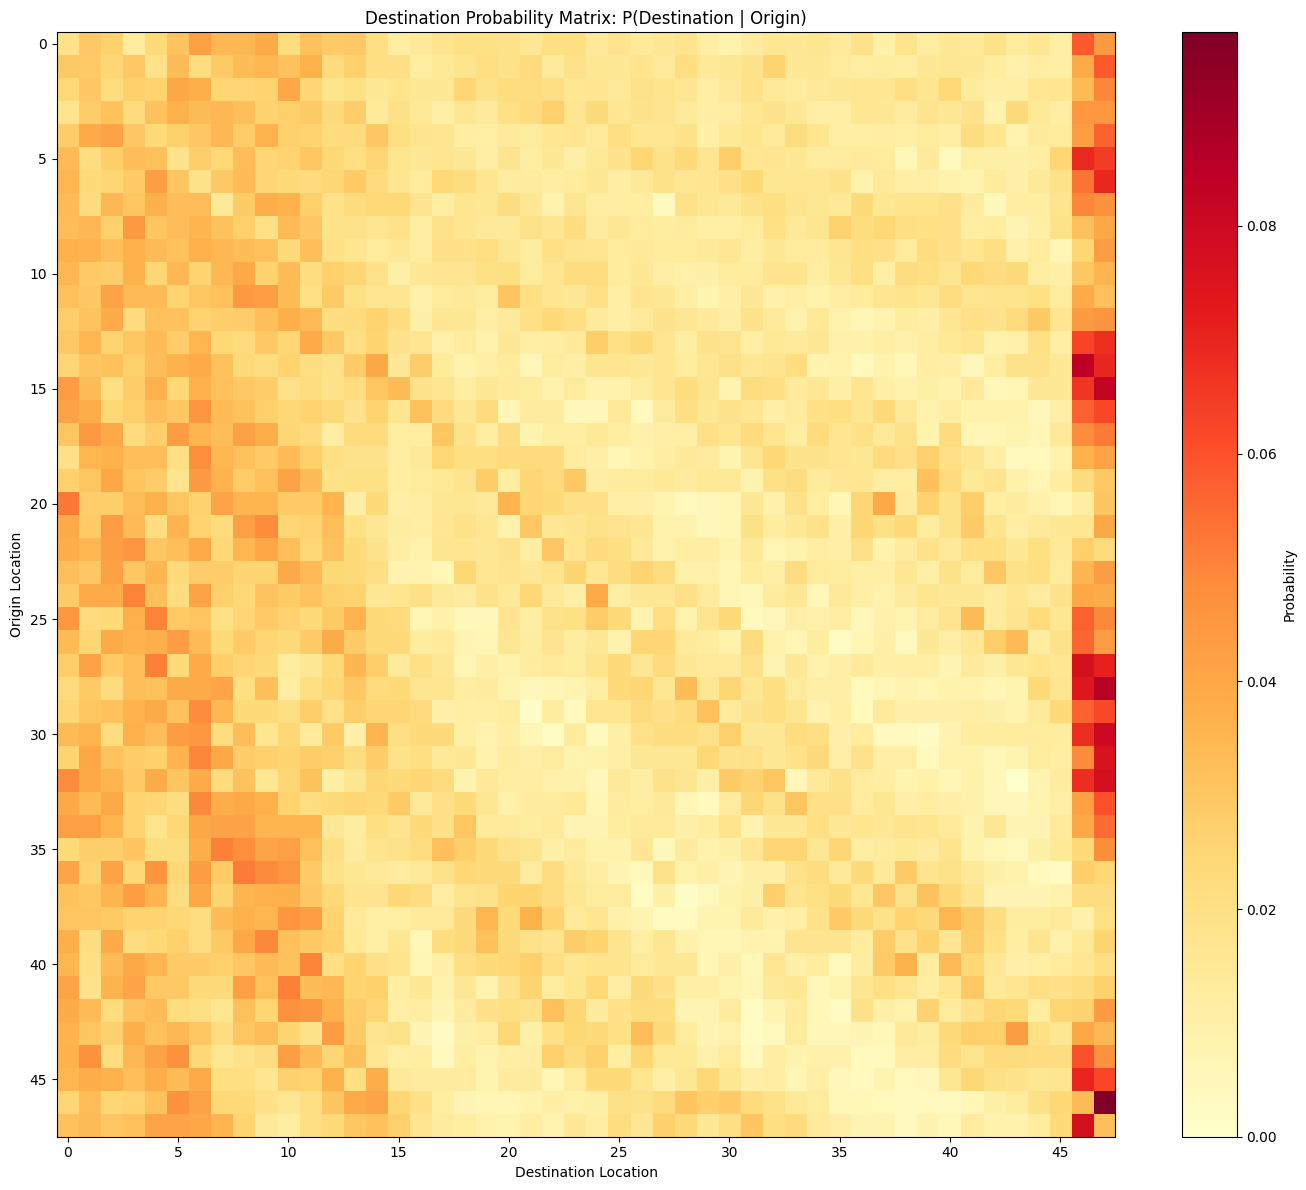

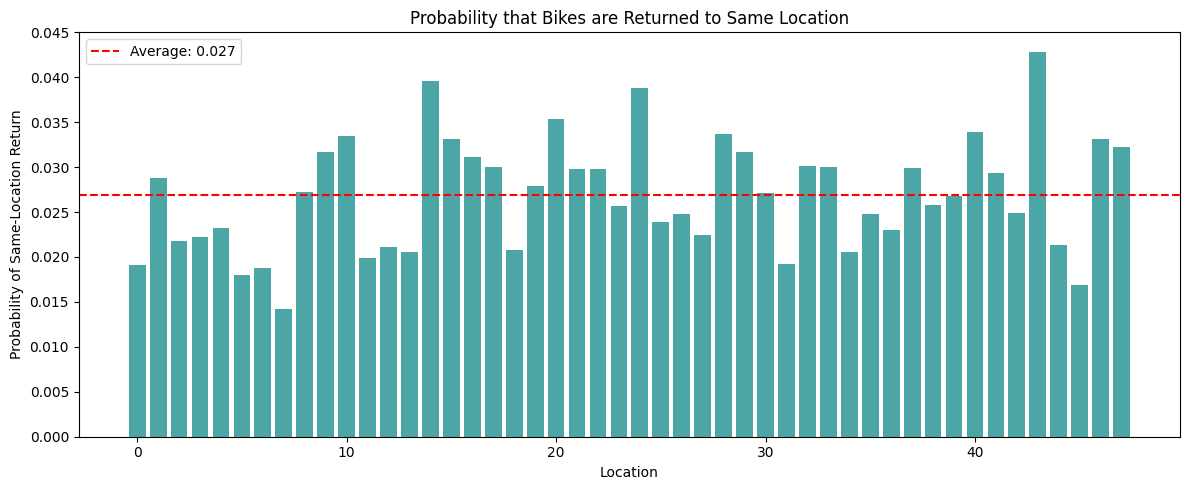


Average same-location return probability: 0.027
Min: 0.014, Max: 0.043

Usage in Simulation:
When a customer withdraws a bike from location i,
sample destination using: np.random.choice(range(48), p=list(dest_prob[i].values()))


In [26]:
# ========== STEP 1: Initialize destination probability matrix ==========
# Create 48x48 matrix: dest_prob[origin][destination] = probability
dest_prob = {i: {j: 0 for j in range(NUM_LOCATIONS)} for i in range(NUM_LOCATIONS)}

# ========== STEP 2: Count trips from each origin to each destination ==========
for day in range(NUM_DAYS):
    day_data = daily_data[day]

    for row in day_data.itertuples():
        if pd.notna(row.wdr_loc) and pd.notna(row.ret_loc):
            origin = int(row.wdr_loc)
            destination = int(row.ret_loc)

            if 0 <= origin < NUM_LOCATIONS and 0 <= destination < NUM_LOCATIONS:
                dest_prob[origin][destination] += 1  # Count this O-D pair

# ========== STEP 3: Normalize to get probabilities ==========
# For each origin, divide by total trips to get probability distribution
for origin in range(NUM_LOCATIONS):
    total_trips = sum(dest_prob[origin].values())

    if total_trips > 0:
        # Convert counts to probabilities (sum will equal 1.0)
        for destination in range(NUM_LOCATIONS):
            dest_prob[origin][destination] /= total_trips
    else:
        # Uniform distribution if no data available
        for destination in range(NUM_LOCATIONS):
            dest_prob[origin][destination] = 1.0 / NUM_LOCATIONS

# ========== STEP 4: Display sample results ==========
print("Destination Probabilities (Sample Origins)")
print("="*70)

for sample_origin in [0, 5, 10, 20]:
    print(f"\nOrigin Location {sample_origin}:")

    # Sort destinations by probability (highest first)
    dest_probs_sorted = sorted(dest_prob[sample_origin].items(),
                                key=lambda x: x[1], reverse=True)

    # Show top 5 most likely destinations
    print("  Top 5 destinations:")
    for dest, prob in dest_probs_sorted[:5]:
        print(f"    Location {dest}: {prob:.3f} ({prob*100:.1f}%)")

    # Highlight same-location return rate
    same_loc_prob = dest_prob[sample_origin][sample_origin]
    print(f"  Same-location return probability: {same_loc_prob:.3f} ({same_loc_prob*100:.1f}%)")

# ========== STEP 5: Create heatmap visualization ==========
import numpy as np

# Convert dictionary to 2D array
dest_matrix = np.zeros((NUM_LOCATIONS, NUM_LOCATIONS))
for i in range(NUM_LOCATIONS):
    for j in range(NUM_LOCATIONS):
        dest_matrix[i][j] = dest_prob[i][j]

plt.figure(figsize=(14, 12))
plt.imshow(dest_matrix, cmap='YlOrRd', aspect='auto', interpolation='nearest')
plt.colorbar(label='Probability')
plt.xlabel('Destination Location')
plt.ylabel('Origin Location')
plt.title('Destination Probability Matrix: P(Destination | Origin)')
plt.xticks(range(0, NUM_LOCATIONS, 5), range(0, NUM_LOCATIONS, 5))
plt.yticks(range(0, NUM_LOCATIONS, 5), range(0, NUM_LOCATIONS, 5))
plt.tight_layout()
plt.show()

# ========== STEP 6: Analyze same-location return rates ==========
# Extract diagonal of matrix (bikes returned to same location)
same_loc_returns = [dest_prob[i][i] for i in range(NUM_LOCATIONS)]

plt.figure(figsize=(12, 5))
plt.bar(range(NUM_LOCATIONS), same_loc_returns, color='teal', alpha=0.7)
plt.xlabel('Location')
plt.ylabel('Probability of Same-Location Return')
plt.title('Probability that Bikes are Returned to Same Location')
plt.axhline(y=np.mean(same_loc_returns), color='red', linestyle='--',
            label=f'Average: {np.mean(same_loc_returns):.3f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAverage same-location return probability: {np.mean(same_loc_returns):.3f}")
print(f"Min: {min(same_loc_returns):.3f}, Max: {max(same_loc_returns):.3f}")

print("\nUsage in Simulation:")
print("When a customer withdraws a bike from location i,")
print("sample destination using: np.random.choice(range(48), p=list(dest_prob[i].values()))")

### Discussion of restuls Question 4
The heatmap shows that bikes are returned to many different locations, not just one or two. There is no strong diagonal pattern, meaning people usually do not bring the bike back to where they took it. The bar chart confirms this: same-station returns are low. So most trips are one-way, and bikes move around the network instead of staying in one place.

This method is effective because it directly uses real historical trip patterns to model where customers return bikes. As a result, the simulated destination choices closely match actual user behaviour, making the system more realistic.

### Assumptions
1. Past origin–destination patterns represent future behaviour.
2. Uniform probabilities are reasonable when no data exist.

## 5. Travel Times

To estimate travel times between all location pairs, I use a hybrid approach. For pairs with sufficient observations (≥5 trips), I use empirical mean and standard deviation. For rare pairs, I fit a linear model (travel_time = a + b × distance) based on Euclidean distance and use that to predict travel times. This ensures all 48×48 pairs have realistic estimates.

Total valid trips analyzed: 49359
Distance range: 0.00 to 18.25
Travel time range: 0.00 to 5.47 hours

Linear Model: travel_time = 0.2672 + 0.0711 × distance
Implied speed: 14.06 distance units per hour


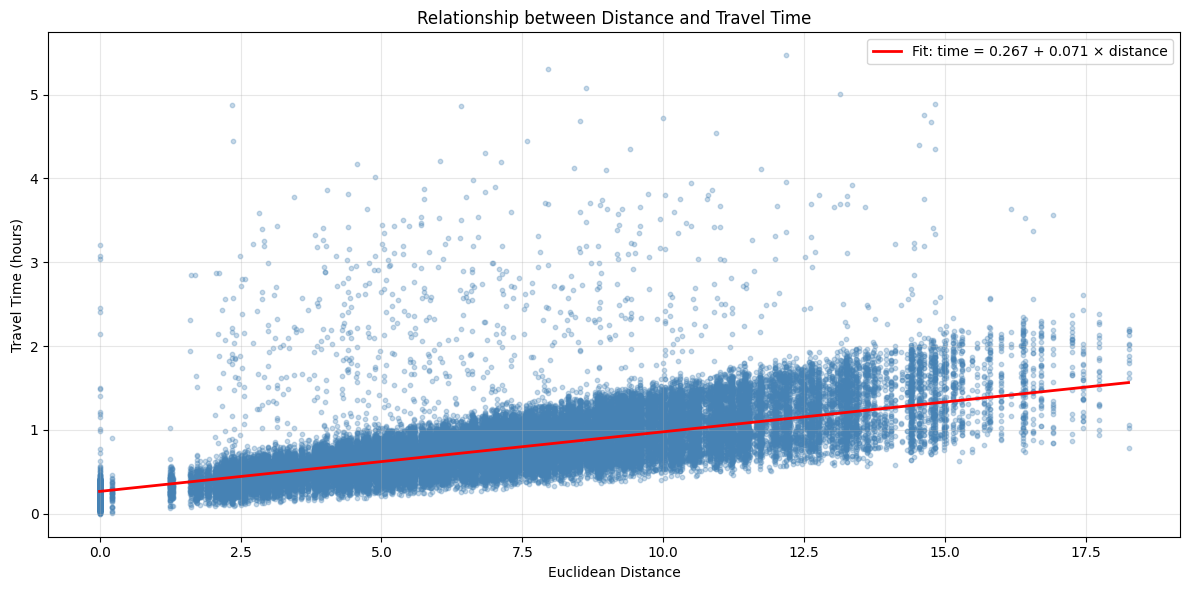

/tmp/ipython-input-411925946.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_clean['predicted_time'] = a + b * trips_clean['distance']
/tmp/ipython-input-411925946.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_clean['residual'] = trips_clean['travel_time'] - trips_clean['predicted_time']


Residual standard deviation: 0.1942 hours

Sample Travel Time Estimates (Origin → Destination)

Location 0 → Location 5:
  Distance: 4.54
  Mean travel time: 0.64 hours (38.5 minutes)
  Std deviation: 0.41 hours
  Data source: empirical (45 observations)

Location 0 → Location 20:
  Distance: 6.03
  Mean travel time: 0.68 hours (40.9 minutes)
  Std deviation: 0.19 hours
  Data source: empirical (28 observations)

Location 10 → Location 30:
  Distance: 11.64
  Mean travel time: 1.11 hours (66.4 minutes)
  Std deviation: 0.27 hours
  Data source: empirical (19 observations)

Location 15 → Location 15:
  Distance: 0.00
  Mean travel time: 0.24 hours (14.1 minutes)
  Std deviation: 0.09 hours
  Data source: empirical (26 observations)

Location 20 → Location 40:
  Distance: 3.20
  Mean travel time: 0.50 hours (30.1 minutes)
  Std deviation: 0.12 hours
  Data source: empirical (14 observations)

2233 O-D pairs have observed data
71 pairs use model-based estimates


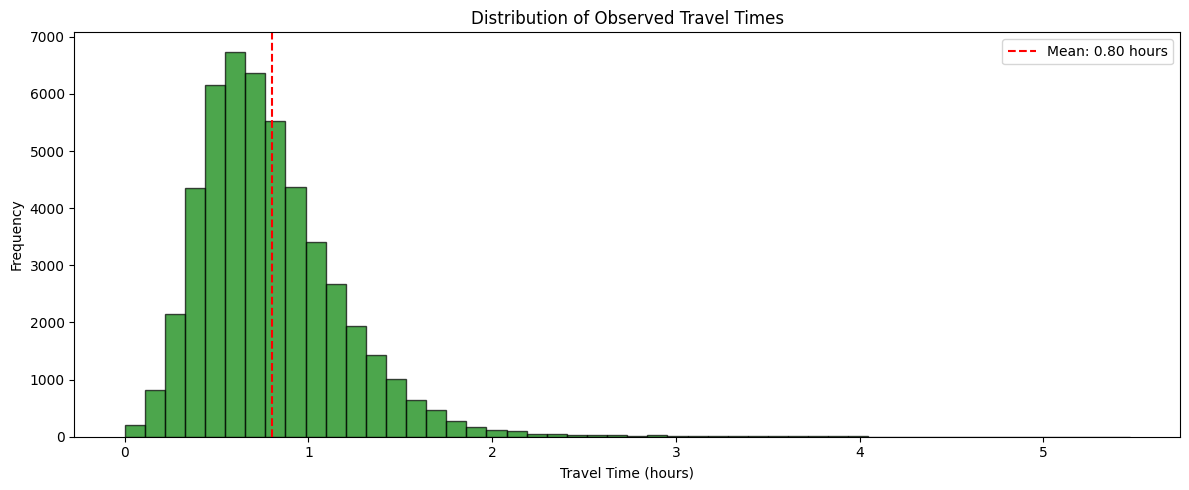


Usage in Simulation:
Sample travel time: travel_time = np.random.normal(mean, std)
Ensure positive: travel_time = max(travel_time, 0.01)


In [27]:
# STEP 1: Extract trip data with travel times and distances
trip_data = []

for day in range(NUM_DAYS):
    day_data = daily_data[day]

    for row in day_data.itertuples():
        if pd.notna(row.wdr_loc) and pd.notna(row.ret_loc):
            origin = int(row.wdr_loc)
            destination = int(row.ret_loc)

            if 0 <= origin < NUM_LOCATIONS and 0 <= destination < NUM_LOCATIONS:
                # Calculate travel time (return time - withdrawal time)
                travel_time = row.ret_t - row.wdr_t

                # Only include same-day trips (0 < time < 24 hours)
                if 0 < travel_time < 24:
                    # Calculate Euclidean distance using Location class
                    distance = locations[origin].distance(locations[destination])

                    trip_data.append({
                        'origin': origin,
                        'destination': destination,
                        'travel_time': travel_time,
                        'distance': distance
                    })

trips_df = pd.DataFrame(trip_data)

print(f"Total valid trips analyzed: {len(trips_df)}")
print(f"Distance range: {trips_df['distance'].min():.2f} to {trips_df['distance'].max():.2f}")
print(f"Travel time range: {trips_df['travel_time'].min():.2f} to {trips_df['travel_time'].max():.2f} hours")

#  STEP 2: Visualize distance vs travel time relationship
plt.figure(figsize=(12, 6))
plt.scatter(trips_df['distance'], trips_df['travel_time'],
            alpha=0.3, s=10, color='steelblue')
plt.xlabel('Euclidean Distance')
plt.ylabel('Travel Time (hours)')
plt.title('Relationship between Distance and Travel Time')
plt.grid(True, alpha=0.3)

# STEP 3: Fit linear regression model
from numpy.polynomial import Polynomial

# Remove outliers (top 5% of travel times)
trips_clean = trips_df[trips_df['travel_time'] < trips_df['travel_time'].quantile(0.95)]

# Fit model: travel_time = a + b × distance
p = Polynomial.fit(trips_clean['distance'], trips_clean['travel_time'], deg=1)
a, b = p.convert().coef  # a = intercept, b = slope

print(f"\nLinear Model: travel_time = {a:.4f} + {b:.4f} × distance")
if b > 0:
    print(f"Implied speed: {1/b:.2f} distance units per hour")

# Plot regression line
distances_plot = np.linspace(0, trips_df['distance'].max(), 100)
times_plot = a + b * distances_plot
plt.plot(distances_plot, times_plot, 'r-', linewidth=2,
         label=f'Fit: time = {a:.3f} + {b:.3f} × distance')
plt.legend()
plt.tight_layout()
plt.show()

# STEP 4: Calculate residual standard deviation
# This measures how much actual times vary from predictions
trips_clean['predicted_time'] = a + b * trips_clean['distance']
trips_clean['residual'] = trips_clean['travel_time'] - trips_clean['predicted_time']
residual_std = trips_clean['residual'].std()
print(f"Residual standard deviation: {residual_std:.4f} hours")

# STEP 5: Build travel time estimates for all O-D pairs
travel_times = {
    i: {
        j: {'mean': 0, 'std': 0, 'count': 0}
        for j in range(NUM_LOCATIONS)
    }
    for i in range(NUM_LOCATIONS)
}

#Calculate empirical statistics for pairs with data
for (origin, dest), group in trips_df.groupby(['origin', 'destination']):
    travel_times[origin][dest]['mean'] = group['travel_time'].mean()
    travel_times[origin][dest]['std'] = (
        group['travel_time'].std() if len(group) > 1 else residual_std
    )
    travel_times[origin][dest]['count'] = len(group)

#  Use distance-based model for pairs with insufficient data
MIN_OBSERVATIONS = 5  # Threshold for "sufficient" data

for i in range(NUM_LOCATIONS):
    for j in range(NUM_LOCATIONS):
        if travel_times[i][j]['count'] < MIN_OBSERVATIONS:
            # Use linear model to predict
            distance = locations[i].distance(locations[j])
            travel_times[i][j]['mean'] = a + b * distance
            travel_times[i][j]['std'] = residual_std
            travel_times[i][j]['count'] = 0  # Mark as model-based

# STEP 6: Display sample results
print("\nSample Travel Time Estimates (Origin → Destination)")
print("="*70)

sample_pairs = [(0, 5), (0, 20), (10, 30), (15, 15), (20, 40)]

for origin, dest in sample_pairs:
    if dest < NUM_LOCATIONS:
        mean_time = travel_times[origin][dest]['mean']
        std_time = travel_times[origin][dest]['std']
        count = travel_times[origin][dest]['count']
        distance = locations[origin].distance(locations[dest])

        # Indicate data source
        data_source = "empirical" if count >= MIN_OBSERVATIONS else "model-based"

        print(f"\nLocation {origin} → Location {dest}:")
        print(f"  Distance: {distance:.2f}")
        print(f"  Mean travel time: {mean_time:.2f} hours ({mean_time*60:.1f} minutes)")
        print(f"  Std deviation: {std_time:.2f} hours")
        print(f"  Data source: {data_source} ({count} observations)")

# STEP 7: Summary statistics
pairs_with_data = [
    (i, j, travel_times[i][j]['count'])
    for i in range(NUM_LOCATIONS)
    for j in range(NUM_LOCATIONS)
    if travel_times[i][j]['count'] > 0
]

print(f"\n{len(pairs_with_data)} O-D pairs have observed data")
print(f"{NUM_LOCATIONS * NUM_LOCATIONS - len(pairs_with_data)} pairs use model-based estimates")

# STEP 8: Visualize travel time distribution
plt.figure(figsize=(12, 5))
plt.hist(trips_df['travel_time'], bins=50, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of Observed Travel Times')
plt.axvline(trips_df['travel_time'].mean(), color='red', linestyle='--',
            label=f"Mean: {trips_df['travel_time'].mean():.2f} hours")
plt.legend()
plt.tight_layout()
plt.show()

print("\nUsage in Simulation:")
print("Sample travel time: travel_time = np.random.normal(mean, std)")
print("Ensure positive: travel_time = max(travel_time, 0.01)")

### Discussion of results
The scatterplot shows a clear positive relationship between distance and travel time, though with a lot of variability around the trend. The linear fit captures the main pattern well, and the histogram confirms that most trips last under an hour. Because many O-D pairs have only a few observations, the combined empirical-plus-model approach ensures each pair has a reasonable travel-time estimate. The method produces realistic mean travel times while avoiding extreme values or gaps in the data.

This approach uses real observed travel times whenever possible and relies on a distance-based model only when data are insufficient. It balances realism and completeness: empirical data capture true behaviour, while the model prevents missing values and gives consistent estimates for rare O-D pairs.

### Assumptions
1. Travel time increases approximately linearly with Euclidean distance, also shown in scatter plot.
2. Top 5% of very long trips are outliers.
3. Euclidean distance is a valid measure of distance between stations
4. When few observations exist, the linear model provides a valid fallback estimate.